In [10]:
import pandas as pd
from utils import *

In [11]:
# Get mean accuracy scores over rest of datastream for each config
df_all = pd.read_csv("../reports/model_sizes/v1.csv.zip")
stream_scores = df_all[df_all["optimizer"] == "SGD"]
stream_scores["accuracy"] *= 100
stream_scores["schedule"] = np.where(stream_scores["gamma"] < 1, "Exp", "Fixed")
variables = [
    "base_lr",
    "n_hidden_layers",
    "n_hidden_units",
    "dataset",
    "gamma",
    "schedule",
]
mean_scores = agg_dataframe(stream_scores, cols_to_keep=variables)
mean_scores = mean_scores[variables + ["accuracy_mean"]]
mean_scores = mean_scores.rename(columns={"accuracy_mean": "accuracy"})

In [12]:
# Read data
df = pd.read_csv("../reports/pretune/prequential.csv.zip")
df["accuracy"] *= 100
df["step"] /= 4
df["schedule"] = np.where(df["gamma"] < 1, "Exp", "Fixed")

# Calculate expanding pre-tuning accuracy for each config
df = df.sort_values(by="step")
df["loss"] = df["loss"].clip(df["loss"].quantile(0.99))
variables = ["dataset", "n_hidden_layers", "n_hidden_units", "n_samples", "schedule"]
dfs = []
for params, dfg in df.groupby(variables + ["base_lr", "gamma", "seed"]):
    dfg["expanding_accuracy"] = dfg["accuracy"].expanding().mean()
    dfs.append(dfg)
df = pd.concat(dfs)
# Get LRs that yield the largest expanding accuracy scores for each config
best_lrs_pretune = get_best_params(
    df,
    params=["base_lr", "gamma"],
    fixed_params=variables + ["step", "seed"],
    metric=f"expanding_accuracy",
)
best_lrs_pretune = best_lrs_pretune[
    variables + ["base_lr", "gamma", "step", "seed", "loss"]
]
# Merge mean accuracy scores over datastreams into best parameters based on pre-tuning
pretuning_scores = best_lrs_pretune.merge(
    mean_scores,
    on=[
        "base_lr",
        "n_hidden_layers",
        "n_hidden_units",
        "dataset",
        "gamma",
        "schedule",
    ],
)

In [13]:
# Read data
dfb = pd.read_csv("../reports/pretune/batch_mode.zip")
dfb = dfb[dfb["n_samples"] == 1000]
dfb["best_val_accuracy"] *= 100
dfb["schedule"] = np.where(dfb["gamma"] < 1, "Exp", "Fixed")
best_lrs_batch_tune = get_best_params(
    dfb,
    params=["base_lr", "gamma"],
    fixed_params=variables + ["seed"],
    metric=f"best_val_loss",
    mode="min",
)
best_lrs_batch_tune = best_lrs_batch_tune[
    variables + ["base_lr", "gamma", "seed", "best_val_loss"]
]
batch_tuning_scores = best_lrs_batch_tune.merge(
    mean_scores,
    on=[
        "base_lr",
        "n_hidden_layers",
        "n_hidden_units",
        "dataset",
        "gamma",
        "schedule",
    ],
).rename(
    columns={
        "accuracy": "accuracy_batch",
        "base_lr": "base_lr_batch",
        "gamma": "gamma_batch",
    }
)
merge_vars = [
    "dataset",
    "n_hidden_layers",
    "n_hidden_units",
    "seed",
    "drift_confidence",
    "schedule",
]
batch_tuning_scores = batch_tuning_scores[
    merge_vars + ["accuracy_batch", "base_lr_batch", "gamma_batch"]
]
pretuning_scores = pretuning_scores.merge(batch_tuning_scores, on=merge_vars)

In [14]:
best_lrs_pretune['base_lr'].value_counts()

base_lr
0.50000    19438
0.25000    13301
0.12500    12657
0.06250     4463
1.00000     3844
0.03125     2297
Name: count, dtype: int64

In [15]:
# Get best accuracy scores for the datastreams
fixed_vars = [
    "dataset",
    "n_hidden_layers",
    "n_hidden_units",
    "schedule",
    "drift_confidence",
]
best_lr_scores = get_best_params(
    mean_scores,
    params=["base_lr", "gamma"],
    fixed_params=fixed_vars,
    metric="accuracy",
)[fixed_vars + ["accuracy", "base_lr"]]

# Get accuracy scores when choosing random params
dog_lr_scores = df_all['DoG']
dog_lr_scores["accuracy"] *= 100
dog_lr_scores["lr"] = dog_lr_scores["lr_norm"] / np.sqrt(dog_lr_scores["n_params"])
dog_lr_scores = agg_dataframe(
    dog_lr_scores,
    ["dataset", "n_hidden_layers", "n_hidden_units"],
    agg_fns=["mean"],
)
dog_lr_scores = dog_lr_scores.rename(
    columns={"accuracy_mean": "accuracy_dog", "lr_mean": "dog_lr"}
)

best_lr_scores = best_lr_scores.rename(
    columns={"accuracy": "accuracy_upper", "base_lr": "best_lr"}
)
merge_vars = ["dataset", "n_hidden_layers", "n_hidden_units"]
bounds = best_lr_scores.merge(
    dog_lr_scores[merge_vars + ["accuracy_dog", "dog_lr"]], on=merge_vars
)

# Merge random and best accuracy scores into pre-tuning scores
pretuning_scores = pretuning_scores.merge(bounds, on=fixed_vars)
pretuning_scores = pretuning_scores.sort_values(by=["step"])

In [28]:
baselines = [
    {"name": "dog", "linestyle": "dashed", "label": "DoG"},
    {"name": "upper", "linestyle": "solid", "label": "Best LR"},
    {"name": "batch", "linestyle": "dotted", "label": "Conventional Tuning"},
]


def make_pretuning_plots(dfp, ax=None, var_y="accuracy", colors={500: "#2C0493", 1000: "#F7DD23"} ,figsize=(5, 3)):
    # cmapper = ValueColorMapper(dfp["n_samples"].unique(), cmap="plasma")
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    for n_samples, df_n_samples in dfp.groupby("n_samples"):
        steps = df_n_samples["step"]
        scores = df_n_samples[f"{var_y}_mean"]
        stds = df_n_samples[f"{var_y}_std"]
        color = colors[n_samples]
        ax.plot(
            steps,
            scores,
            c=color,
            label=f"{n_samples} Samples (ours)",
        )
        ax.fill_between(
            steps,
            scores - stds,
            scores + stds,
            color=color,
            edgecolor="none",
            alpha=0.2,
        )
    for baseline in baselines:
        name = f"{var_y}_{baseline['name']}"
        if name in df_n_samples:
            ax.plot(
                df_n_samples["step"],
                df_n_samples[name],
                linestyle=baseline["linestyle"],
                c="black",
                label=baseline["label"],
                zorder=0
            )
    return ax

In [22]:
real_world_means = pretuning_scores[
    ~pretuning_scores["dataset"].isin(["RBF incr.", "RBF static", "SEA"])
]
rw_means = agg_dataframe(
    pretuning_scores,
    cols_to_keep=[
        "n_samples",
        "n_hidden_layers",
        "n_hidden_units",
        "step",
        "schedule",
        "drift_confidence",
    ],
)
rw_means["dataset"] = "mean"
seed_means = agg_dataframe(
    pretuning_scores,
    cols_to_keep=[
        "dataset",
        "n_samples",
        "n_hidden_layers",
        "n_hidden_units",
        "step",
        "schedule",
        "drift_confidence",
    ],
)
scores = pd.concat([rw_means, seed_means])
scores = scores.rename(
    columns={
        "accuracy_upper_mean": "accuracy_upper",
        "accuracy_dog_mean": "accuracy_dog",
        "dog_lr_mean": "base_lr_dog",
        "accuracy_batch_mean": "accuracy_batch",
        "base_lr_batch_mean": "base_lr_batch",
    }
)

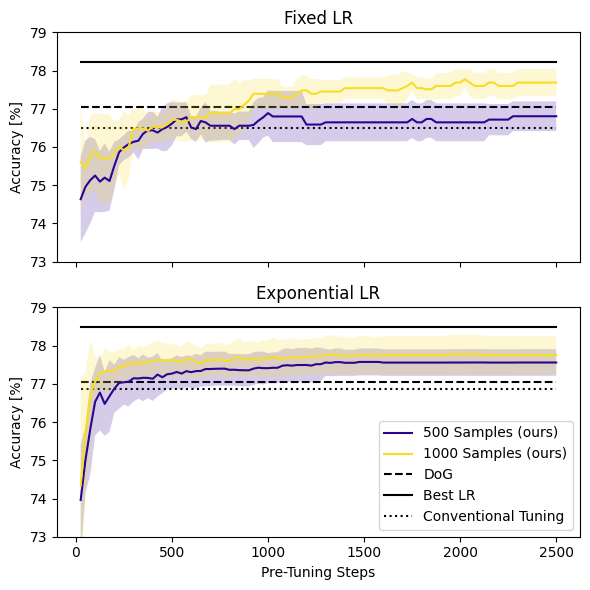

In [29]:
dfp = scores[
    (scores["n_hidden_layers"] == 1)
    & (scores["n_hidden_units"] == 64)
    & (scores["dataset"] == "mean")
]
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True, sharey=True)
make_pretuning_plots(dfp[dfp["schedule"] == "Fixed"], axs[0])
make_pretuning_plots(
    dfp[(dfp["schedule"] == "Exp") & (dfp["drift_confidence"] == 0)], axs[1]
)
axs[1].legend(loc=("lower right"))
axs[1].set_xlabel("Pre-Tuning Steps")
axs[0].set_ylabel("Accuracy [%]")
axs[1].set_ylabel("Accuracy [%]")
axs[0].set_title("Fixed LR", fontsize=12)
axs[1].set_title("Exponential LR", fontsize=12)
axs[1].set_ylim([73, 79])
axs[0].set_ylim([73, 79])

plt.tight_layout()
plt.savefig("../pub/figures/pretune_1x64_fixed_vs_exp_schedule.pdf")

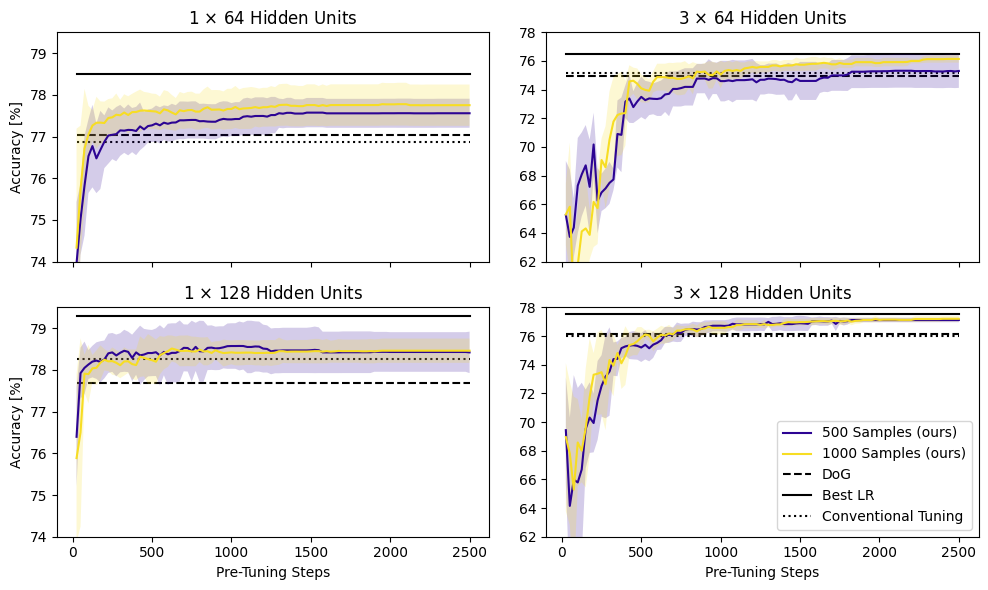

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey="col")
dfp = scores[
    (scores["schedule"] == "Exp")
    & (scores["drift_confidence"] == 0)
    & (scores["dataset"] == "mean")
]
rowmap = {64: 0, 128: 1}
colmap = {1: 0, 3: 1}
for n_units, dfw in dfp.groupby("n_hidden_units"):
    for n_layers, dfl in dfw.groupby("n_hidden_layers"):
        ax = axs[rowmap[n_units], colmap[n_layers]]
        make_pretuning_plots(dfl, ax)
axs[0, 0].set_title(r"1 $\times$ 64 Hidden Units", fontsize=12)
axs[0, 1].set_title(r"3 $\times$ 64 Hidden Units", fontsize=12)
axs[1, 0].set_title(r"1 $\times$ 128 Hidden Units", fontsize=12)
axs[1, 1].set_title(r"3 $\times$ 128 Hidden Units", fontsize=12)
axs[1, 0].set_xlabel("Pre-Tuning Steps")
axs[1, 1].set_xlabel("Pre-Tuning Steps")
axs[0, 0].set_ylabel("Accuracy [%]")
axs[1, 0].set_ylabel("Accuracy [%]")
axs[1, 1].legend()
axs[0, 0].set_ylim([74, 79.5])
axs[0, 1].set_ylim([62, 78])
plt.tight_layout()
plt.savefig("../pub/figures/pretune_architectures_exp_schedule.pdf")

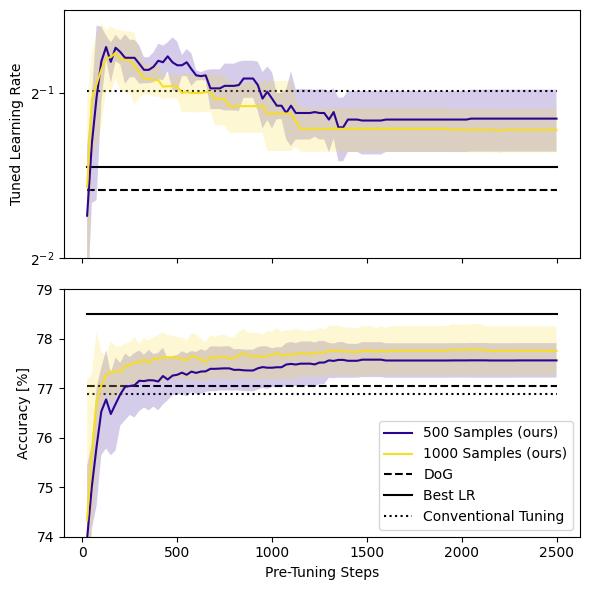

In [31]:
dfp = scores[
    (scores["schedule"] == "Exp")
    & (scores["n_hidden_layers"] == 1)
    & (scores["n_hidden_units"] == 64)
    & (scores["drift_confidence"] == 0)
    & (scores["dataset"] == "mean")
]
dfp = dfp.rename(columns={"best_lr_mean": "base_lr_upper"})
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
make_pretuning_plots(dfp, axs[0], var_y="base_lr")
make_pretuning_plots(dfp, axs[1], var_y="accuracy")
axs[0].set_yscale("log", base=2)
axs[1].set_xlabel("Pre-Tuning Steps")
axs[1].set_ylabel("Accuracy [%]")
axs[0].set_ylabel("Tuned Learning Rate")
axs[1].legend(loc="lower right")
axs[0].set_ylim([2**-2, 2**-0.5])
axs[1].set_ylim([74, 79])
# axs[0].set_ylim([2**-3, 2**0.5])
plt.tight_layout()
plt.savefig("../pub/figures/pretune_1x64_acc_lr_exp_schedule.pdf")

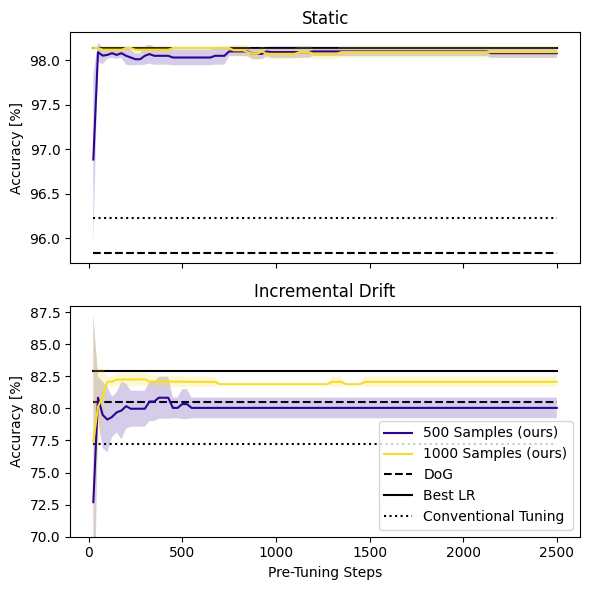

In [32]:
dfp = scores[
    (scores["n_hidden_layers"] == 1)
    & (scores["n_hidden_units"] == 64)
    & (scores["schedule"] == "Exp")
    & (scores['drift_confidence'] == 0)
]
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True, sharey=False)
make_pretuning_plots(dfp[dfp["dataset"] == "RBF static"], axs[0])
make_pretuning_plots(dfp[dfp["dataset"] == "RBF incr."], axs[1])
axs[1].legend(loc=("lower right"))
axs[1].set_xlabel("Pre-Tuning Steps")
axs[0].set_ylabel("Accuracy [%]")
axs[1].set_ylabel("Accuracy [%]")
axs[0].set_title("Static", fontsize=12)
axs[1].set_title("Incremental Drift", fontsize=12)
axs[1].set_ylim([70, 88])
plt.tight_layout()
plt.savefig("../pub/figures/pretune_1x64_static_vs_drift.pdf")